# Importing libraries

In [20]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import pyinputplus as pyip

# Importing dataset

In [21]:
dataset = pd.read_csv('Sales_data.csv')

In [22]:
# look into dataset structure
dataset.head()

,Date,Sales,Units,Stock,SKU,Retailer
0,2014-02-06,0.0,NaN,-0.0,SKU_126,RETAILER_5
1,2014-02-06,0.0,NaN,0.0,SKU_126,RETAILER_6
2,2014-02-06,0.0,NaN,0.0,SKU_126,RETAILER_7
3,2014-02-06,0.0,NaN,0.0,SKU_126,RETAILER_8
4,2014-02-06,0.0,NaN,0.0,SKU_127,RETAILER_0


## Prompt user to enter SKU number for makeing the predictions

In [23]:
print('To make a predictions for sales of specific product, you will need to enter the SKU number for the product.')
sku_number = pyip.inputInt('Please, enter number of product: ')

To make a predictions for sales of specific product, you will need to enter the SKU number for the product.
Please, enter number of product: 127


In [24]:
sku = 'SKU_' + str(sku_number)
print(f'The sales predictions will be made for product labeled "{sku}"')

The sales predictions will be made for product labeled "SKU_127"


# Data preprocessing

In [25]:
# find min. and max. dates in 'Date' column
dataset['Date'].min(), dataset['Date'].max()

('2014-02-06', '2017-10-19')

In [26]:
X = dataset.loc[dataset['SKU'].isin([sku])]

In [27]:
len(X)

244

In [28]:
# Since 'Test_data_Simporter.csv' contains additional columns Units, Stock, SKU and Retailer
# and there is no information on their influence on sales, they are not concidered on further model building process
# negative values in sales column remained, assuming they reflect product rerurns by customer
X = X.iloc[:, 0:2]

In [29]:
X.tail()

,Date,Sales
105387,2017-07-13,0.0
105982,2017-07-20,0.0
106582,2017-07-27,0.0
107183,2017-08-03,0.0
107780,2017-08-10,0.0


In [30]:
# check how many columns have nan values
X.isnull().sum()

Date     0
Sales    0
dtype: int64

In [31]:
# since task is to predict sales for next 6 months, the sales data is groupped by Date
X = X.groupby('Date')['Sales'].sum().reset_index()

In [32]:
X

,Date,Sales
0,2014-02-06,0.37
1,2014-02-13,1.59
2,2014-02-20,0.00
3,2014-02-27,0.76
4,2014-03-05,0.24
...,...,...
179,2017-07-13,0.00
180,2017-07-20,0.00
181,2017-07-27,0.00
182,2017-08-03,0.00


In [33]:
# fill in nan values in case if any with 0
X.fillna(X.dtypes.replace({'float64': 0.0}), downcast='infer', inplace=True)

In [34]:
# change values to date time in columns with date
format = '%Y-%m-%d %H:%M:%S'
X['Date'] = pd.to_datetime(X['Date'] + ' 00:00:00', format=format)
X = X.set_index(pd.DatetimeIndex(X['Date']))

In [35]:
# remove duplicates 'Date' column
X = X.drop('Date', 1)

<ipython-input-35-44f36e5438dc>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X.drop('Date', 1)


In [37]:
# since task is to make predictions for next 6 months and since current date data is patchy
# average daily sales value for month will be used, and start of each month is used as timestamp
y = X['Sales'].resample('MS').mean()

In [38]:
y['2017']

Date
2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
2017-05-01    0.0
2017-06-01    0.0
2017-07-01    0.0
2017-08-01    0.0
Freq: MS, Name: Sales, dtype: float64

# Visualizing Sales Time Series Data

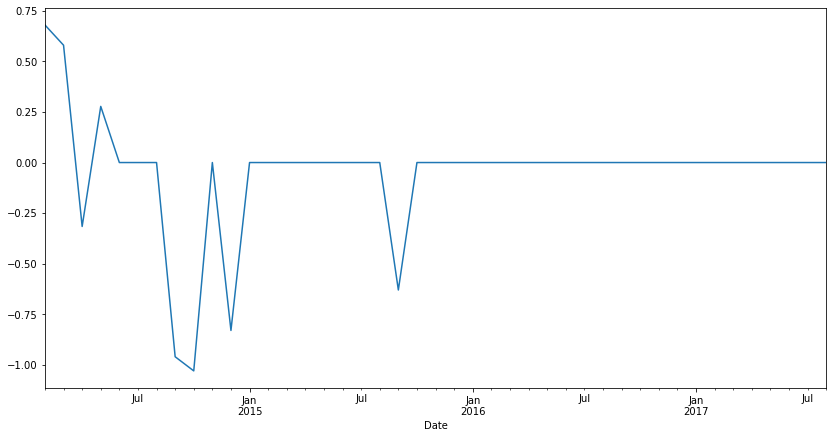

In [39]:
# plot and display our dataset
y.plot(figsize=(14, 7))
plt.show()

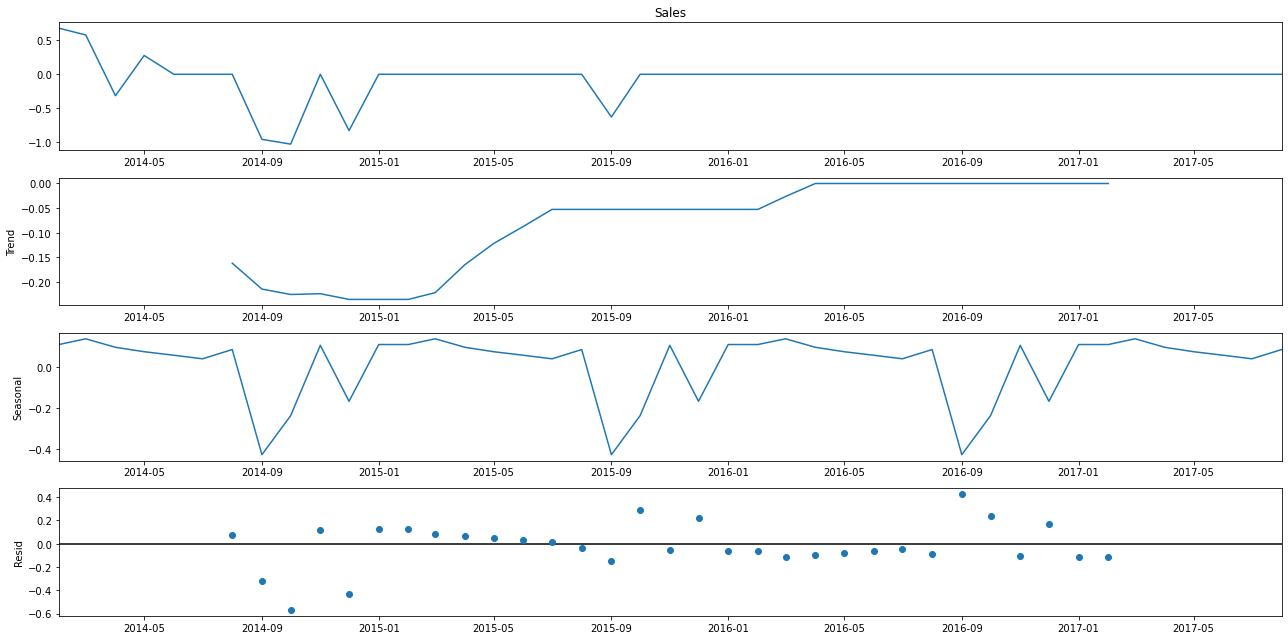

In [40]:
# since data shows obvious seasonality, whith decrease of sales starting from September and continues 
# up untill March (which happens in industries like icecream production or agriculture),
# it would be good to visualize separatly data in terms of seasonality, trend and noise
# such visualization implemented with time-series decomposition method

# set chart size
rcParams['figure.figsize'] = 18, 9
# using time-series decomposition method, build charts
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Above provided charts, proves that company's sales show continues positive growth dynamics, with clear seasonality.

## Time series forecasting with ARIMA

In [41]:
# time-series forecasting done with ARIMA method
# set range for ARIMA model parameters
p = d = q = range(0, 2)
# generate the list of parameters combinations
pdq = list(itertools.product(p, d, q))
# generate the list of seasonal parameters combinations
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# display the examples of generated combinations
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [43]:
# find optimal set of parameters (combinations) that wil give best model performance using grid search

warnings.filterwarnings("ignore") # specify to ignore warning messages

# this dataframe will contain all calculated AIC values for later model best fit
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(maxiter=200)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic > 0:
                AIC_list = AIC_list.append(
                    pd.DataFrame([[ param ,  param_seasonal , results.aic ]],
                                 columns=['param','param_seasonal','AIC']), ignore_index=True)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:17.79227452886748
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-40.62173691999766
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:15.65348543081563
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-14.423060394566157
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-51.14330148124353
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-50.3362630696616
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-16.32642308201319
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-14.333792515376146
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13.923845892468266
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-36.151200695139586
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:14.412025299622226
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-11.566561583748427
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-51.15664849109473
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-50.94801165122752
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-14.696562491481462
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-11.129902118322867
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:35.17096228310119
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-18.04993

In [44]:
# find minimum value in AIC
m = np.amin(AIC_list['AIC'].values)
# find index number for lowest AIC
l = AIC_list['AIC'].tolist().index(m)
# find minimal parameters
Min_AIC_list = AIC_list.iloc[l,:]
# display the best optimal AIC value for our model
print(f'ARIMA {Min_AIC_list["param"]}x{Min_AIC_list["param_seasonal"]} with AIC {m} is optimal value for our model')

ARIMA (0, 1, 0)x(1, 1, 1, 12) with AIC 0.1772576183074852 is optimal value for our model


## Fitting the ARIMA model

In [45]:
# run data series analysis with Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
# and display the results in table
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(0, 1, 0, 12),
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3914      0.311     -1.258      0.208      -1.001       0.219
ma.L1         -0.3170      0.319     -0.994      0.320      -0.942       0.308
sigma2         0.1045      0.019      5.628      0.000       0.068       0.141


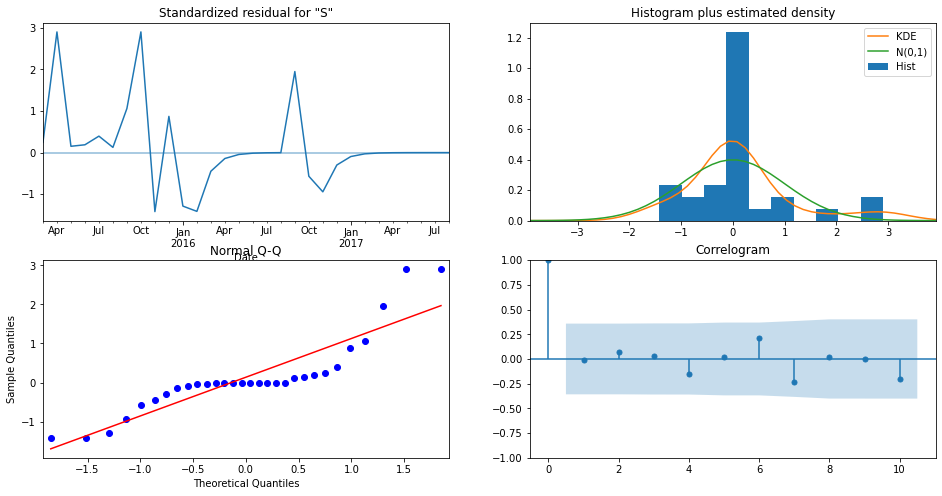

In [46]:
# to check for any unusual model behaviour, make model diagnostics and display the results
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

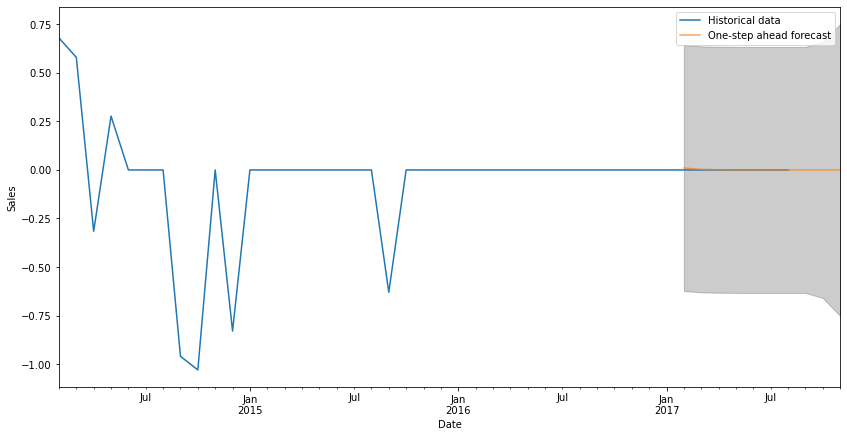

In [49]:
# to compare accuracy of model predictions, run comparizon of real data and predicted, 
# starting from '2017-02-01'
pred = results.get_prediction(start=pd.to_datetime('2017-02-01'), end=pd.to_datetime('2017-10-19'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='Historical data')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Acording to the plot illustration, model predictions goes very closely to the actual data, capturing seasonality of the sales.

In [50]:
# calculate Mean Squared Error for model forecasts and display the average of squarred of errors
y_pred = pred.predicted_mean
y_pred = y_pred [:-1]
y_true = y['2017-02-01':]
mse = ((y_pred - y_true) ** 2).mean()

In [51]:
print(f'The Mean Squared Error of model forecasts is {round(mse, 2)}')

The Mean Squared Error of model forecasts is 0.0


In [52]:
print(f'The Root Mean Squared Error of model forecasts is {round(np.sqrt(mse), 2)}')

The Root Mean Squared Error of model forecasts is 0.0


In [53]:
# calculate persentage error of our model and display the results
model_error = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'The model gives in average {round(model_error, 2)}% of errors in making forecasts comparing to actual data!')

The model gives in average inf% of errors in making forecasts comparing to actual data!


## Producing and visualizing forecasts for next 6 months

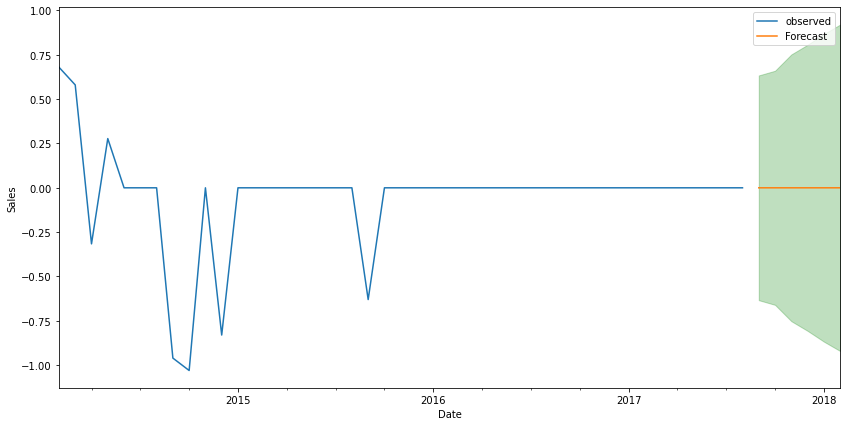

In [54]:
pred_uc =results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='g', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')


plt.legend()
plt.show()

## Display the forecasted data for next 6 months

In [55]:
# make predictions for next 6 months
pred_tbl = results.forecast(steps=6)

In [56]:
# display results of forecasts as table
pd.DataFrame({'Projected Date':pred_tbl.index, 'Sales':pred_tbl.values})

,Projected Date,Sales
0,2017-09-01,0.000003
1,2017-10-01,0.000002
2,2017-11-01,0.000002
3,2017-12-01,0.000002
4,2018-01-01,0.000002
5,2018-02-01,0.000002
